In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from collections import Counter

<h3>1. Loading Data / Basic Info<h3>

In [2]:
og_df = pd.read_csv('Data/healthcare-dataset-stroke-data.csv')
og_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [3]:
og_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
for col in og_df.columns:
    if og_df[col].dtype == "object":
        print(og_df[col].value_counts())
        print("\n")
        
for col in og_df.columns:
    if og_df[col].dtype == "int64" and col != "id":
        print(og_df[col].value_counts())
        print("\n")


Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


Yes    3353
No     1757
Name: ever_married, dtype: int64


Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


0    4612
1     498
Name: hypertension, dtype: int64


0    4834
1     276
Name: heart_disease, dtype: int64


0    4861
1     249
Name: stroke, dtype: int64




In [5]:
og_df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

<h3>3. Pre-Visualization Data Cleanup<h3>

In [6]:
main_df = og_df

#removed the gender "Other" from the dataset since it only has 1 entry
other_index = main_df.index[main_df["gender"] == "Other"]
main_df = main_df.drop(other_index)

#removed the "id" column since it is not needed
main_df = main_df.drop(columns=["id"])


#split data into training and test, to prevent data leakage
features_train, features_test, target_train, target_test = train_test_split(main_df.drop(columns=["stroke"]), main_df["stroke"], test_size=0.2, random_state=42, stratify = main_df["stroke"])


#replaced NaN values in the "bmi" column with the average value of the column
average_bmi = features_train["bmi"].mean()
features_train["bmi"].fillna(average_bmi, inplace=True)
features_test["bmi"].fillna(average_bmi, inplace=True)


#categorized ages into age groups
bins = [0, 13, 20, 40, 60, 120]
labels = ["Children", "Teenagers", "Young Adults", "Middle-aged Adults", "Seniors"]
main_df["age_group"] = pd.cut(main_df["age"], bins=bins, labels=labels, right=False)

features_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
845,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked
3745,Female,29.0,0,0,No,Private,Urban,84.19,21.2,never smoked
4184,Female,35.0,0,0,Yes,Private,Rural,119.40,22.9,never smoked
3410,Male,38.0,0,0,Yes,Private,Rural,108.68,32.7,never smoked
284,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown


<h3>4. Visualization<h3>

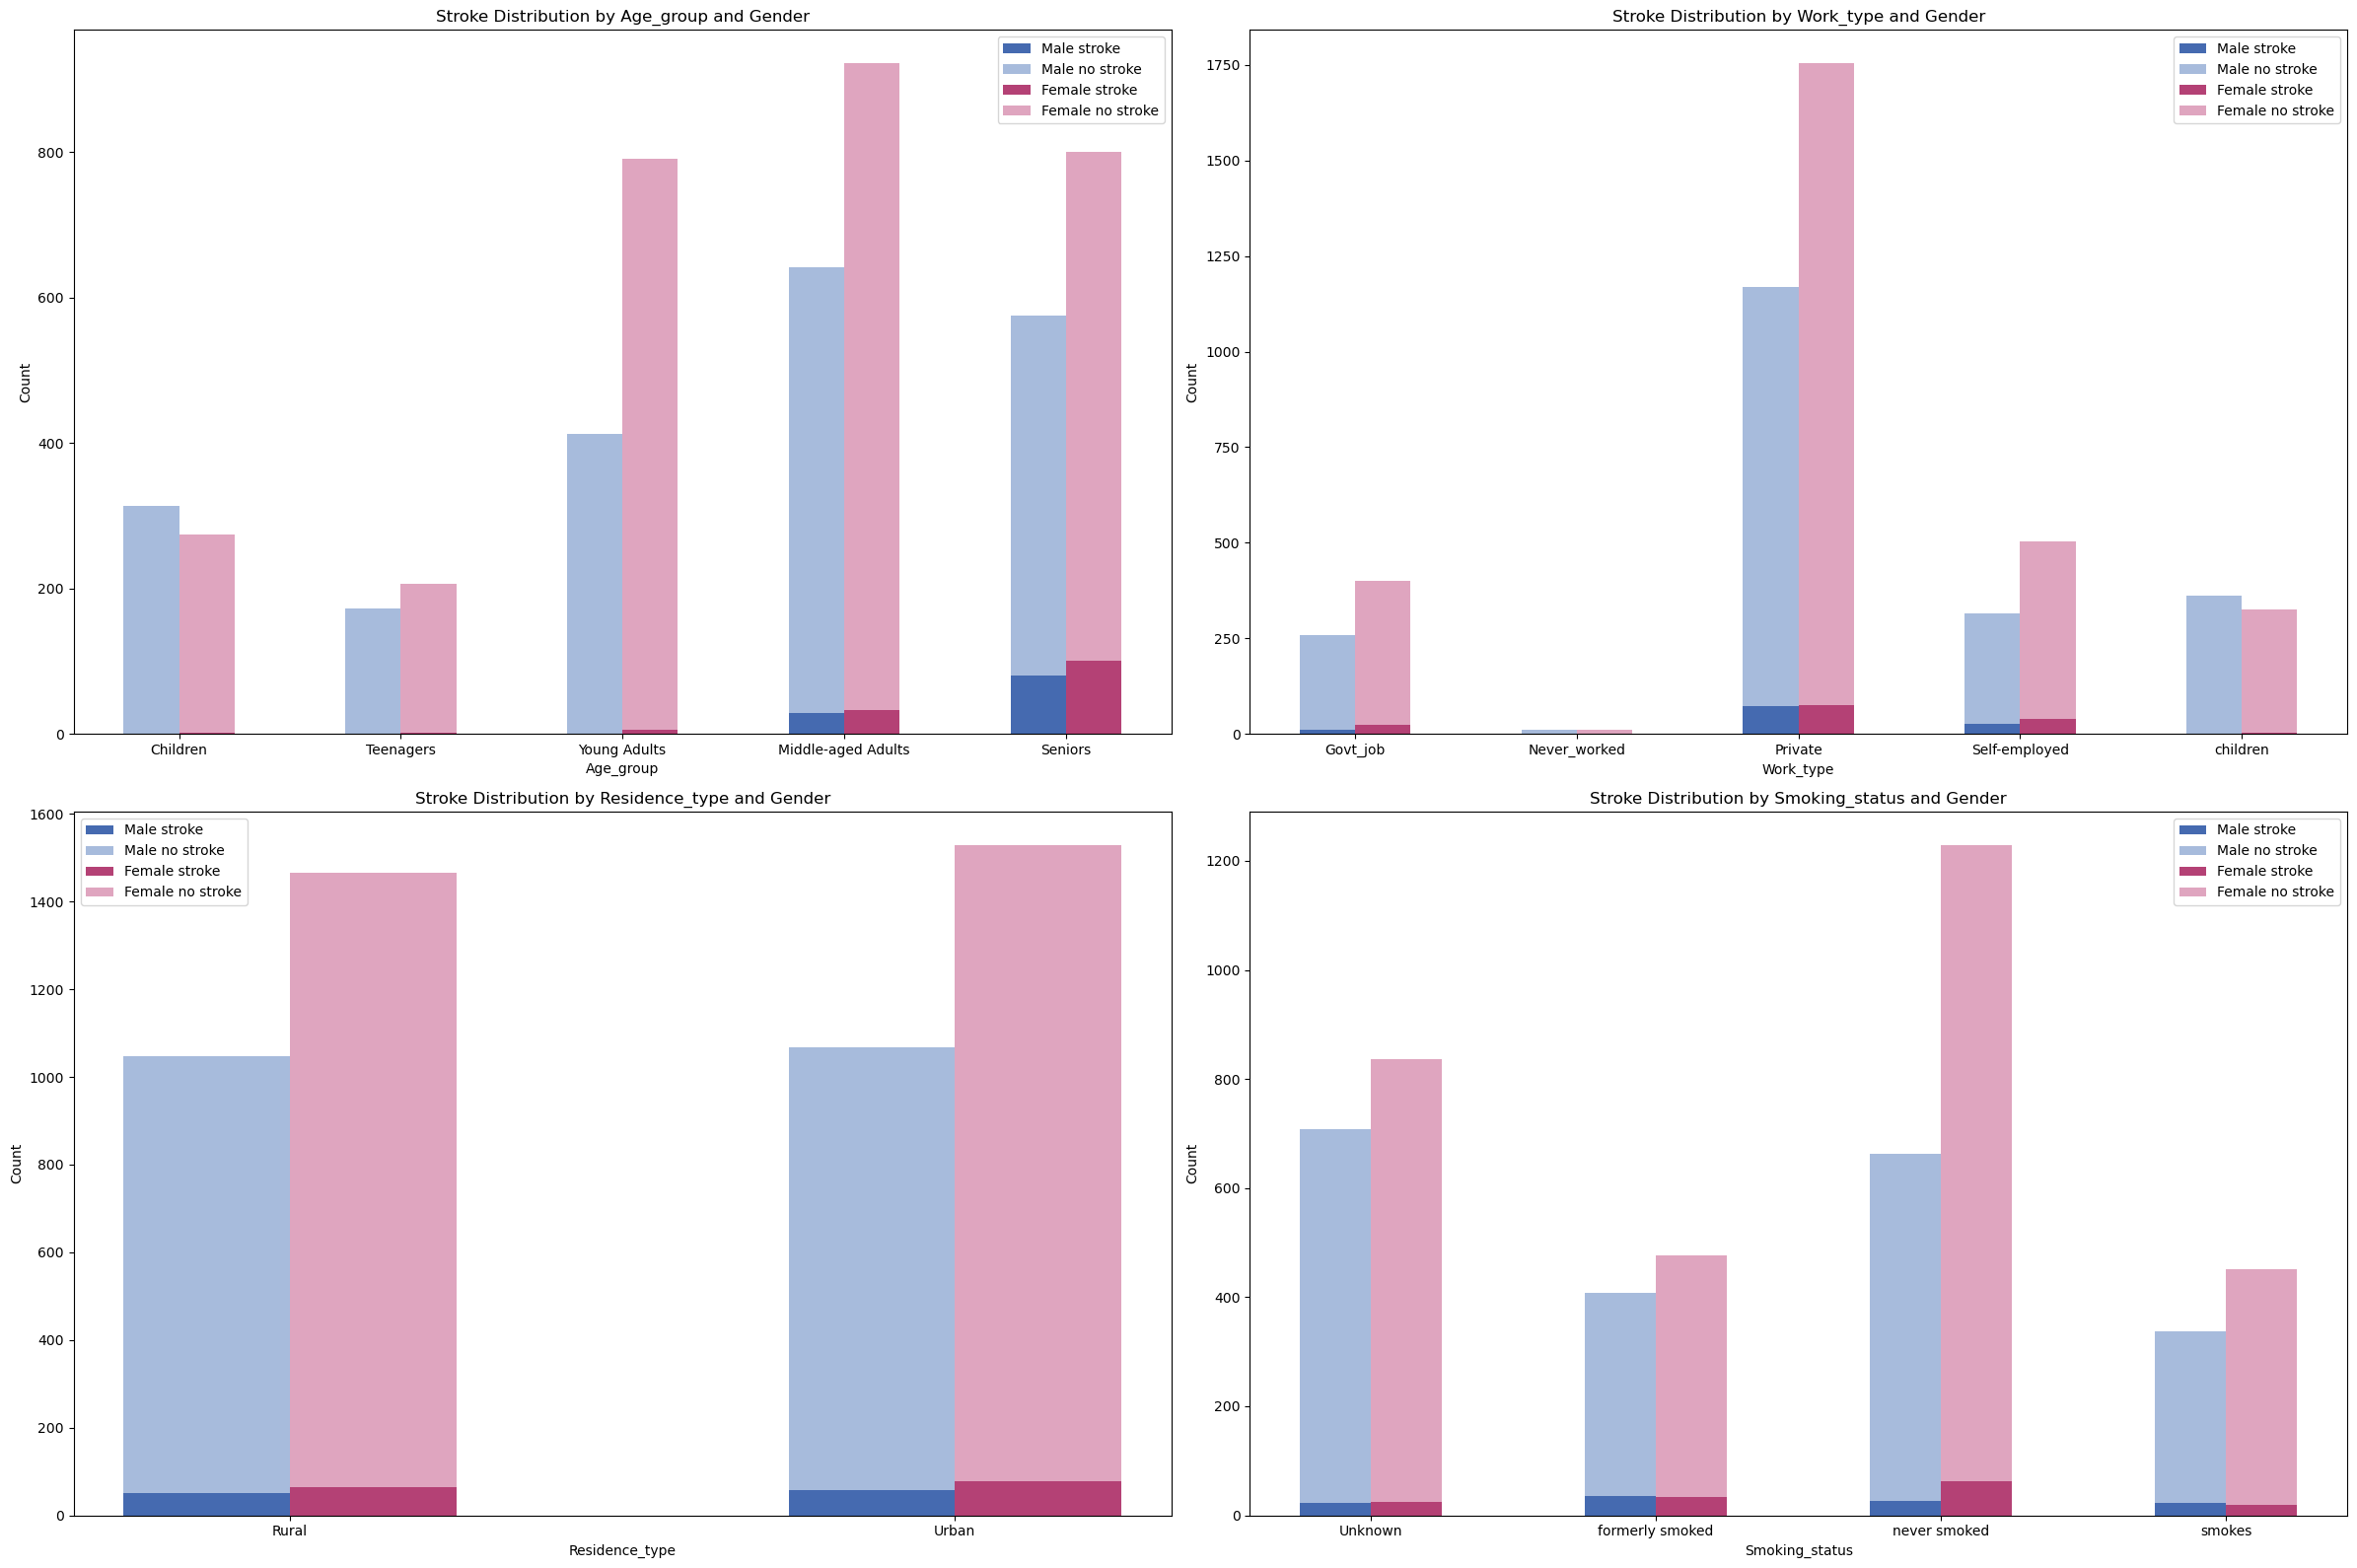

In [7]:
# List of variables to group by
group_vars = ["age_group", "work_type", "Residence_type", "smoking_status"]

# Create 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(24, 16))

# Flatten axs to make it easier to iterate over
axs = axs.flatten()

# Set width of bar
barWidth = 0.25



# Iterate over group_vars and axs simultaneously
for var, ax in zip(group_vars, axs):
    # Group by var, "gender" and "stroke" and get the size of each group
    grouped = main_df.groupby([var, "gender", "stroke"]).size().unstack(level=[1, 2], fill_value=0)
    
    # Set position of bar on X axis
    r1 = np.arange(len(grouped.index))
    r2 = [x + barWidth for x in r1]

    # Create bars for each group
    for i, gender in enumerate(["Male", "Female"]):
        r = r1 if gender == "Male" else r2
        ax.bar(
            r, 
            grouped[(gender, 1)], 
            color="#456AB0" if gender == "Male" else "#B44175",
            width=barWidth,
            label=f"{gender} stroke"
        )
        ax.bar(
            r, 
            grouped[(gender, 0)], 
            bottom=grouped[(gender, 1)], 
            color="#A7BBDC" if gender == "Male" else "#DFA5BF", 
            width=barWidth,
            label=f"{gender} no stroke"
        )

    # Plot chart
    ax.set_xticks([r + barWidth/2 for r in range(len(grouped.index))])
    ax.set_xticklabels(grouped.index.astype(str))
    ax.legend()
    ax.set_xlabel(var.capitalize())
    ax.set_ylabel("Count")
    ax.set_title(f"Stroke Distribution by {var.capitalize()} and Gender")

# Display plots
plt.tight_layout()
plt.show()

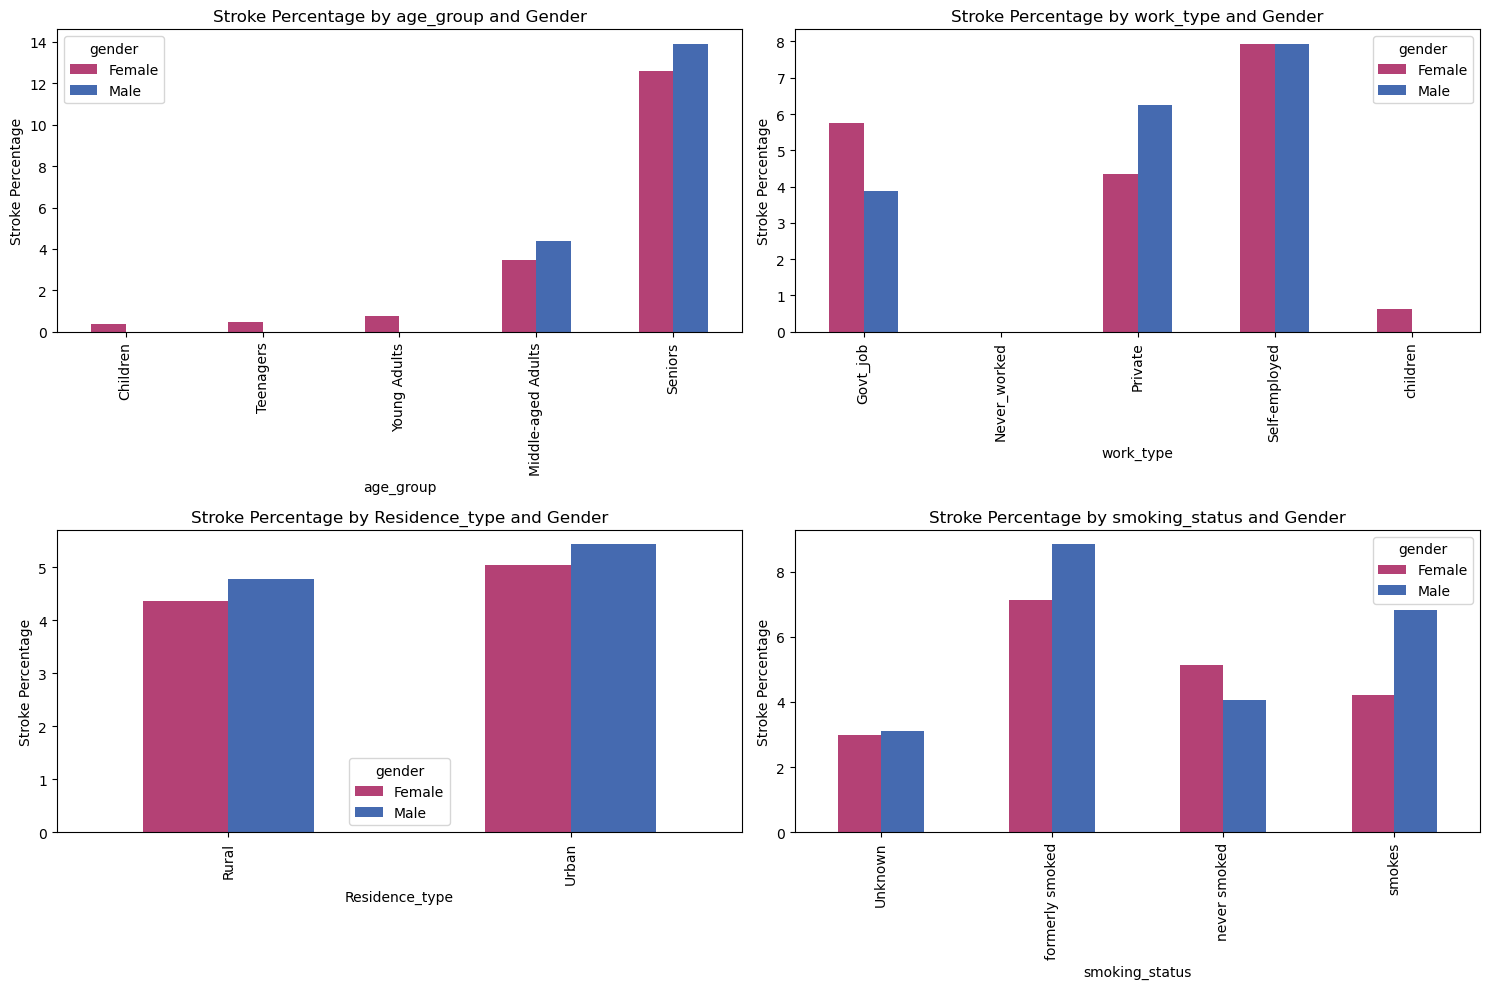

In [8]:
variables = ["age_group", "work_type", "Residence_type", "smoking_status"]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, var in enumerate(variables):
    ax = axs[i//2, i%2]
    grouped = main_df.groupby([var, "gender"])
    total = grouped.size()
    stroke_cases = grouped['stroke'].sum()
    stroke_percentage = (stroke_cases / total) * 100
    result = stroke_percentage.reset_index(name='stroke_percentage')
    
    result.pivot(index=var, columns="gender", values="stroke_percentage").plot(kind='bar', ax=ax, color=["#B44175", "#456AB0"])
    ax.set_title(f'Stroke Percentage by {var} and Gender')
    ax.set_ylabel('Stroke Percentage')

plt.tight_layout()
plt.show()

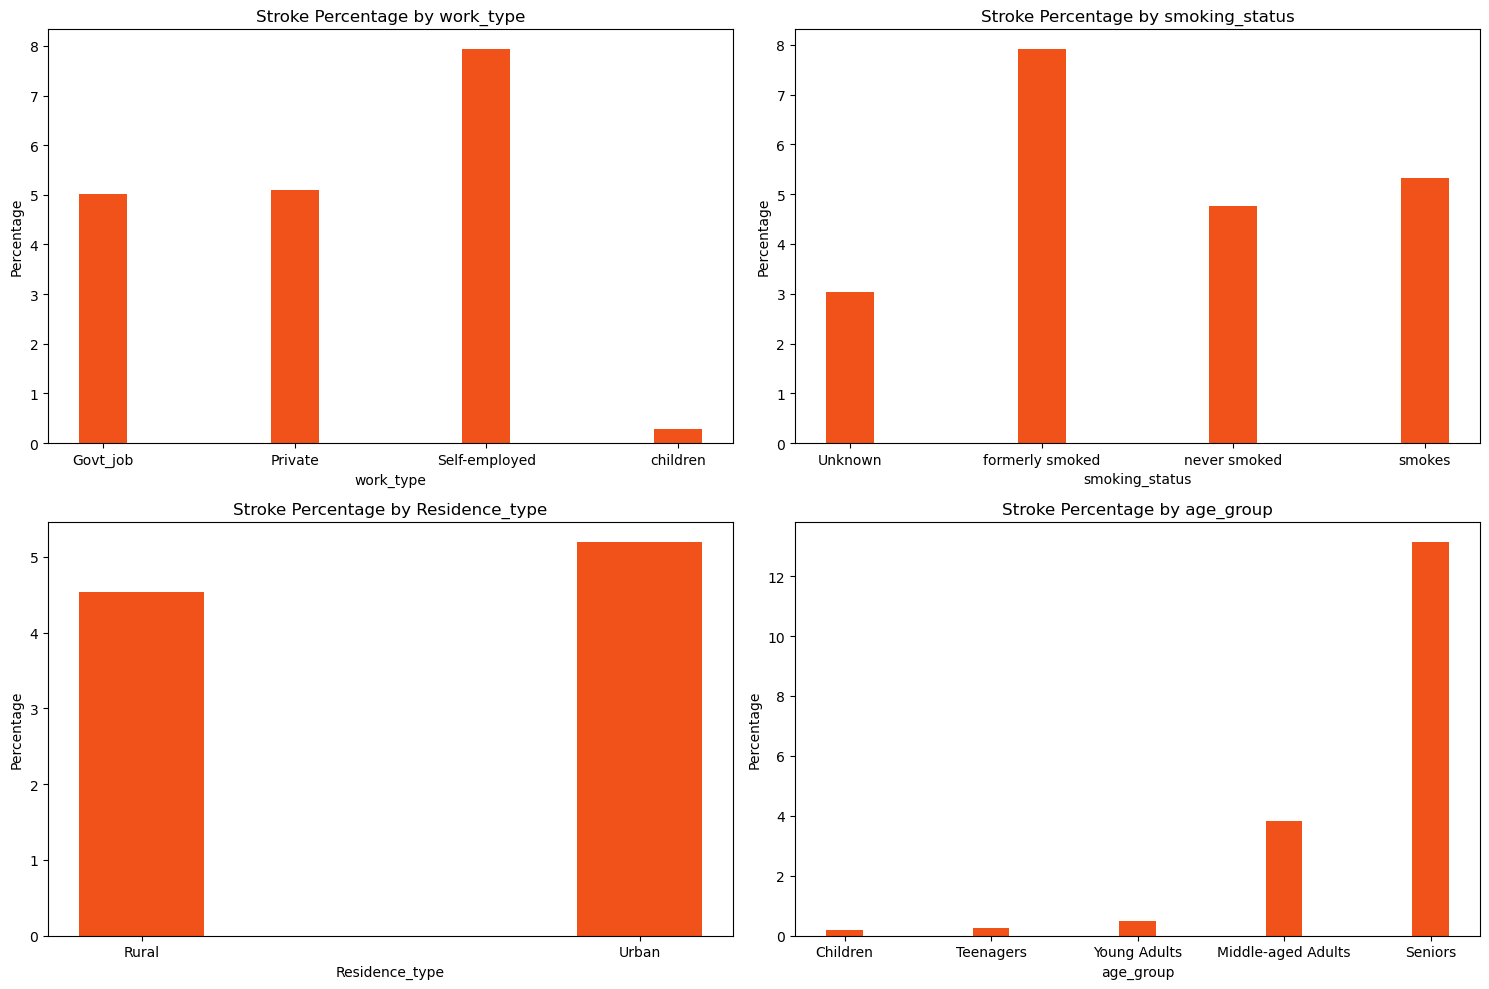

In [9]:
def calculate_percentage(main_df, column):
    group = main_df.groupby(column)['stroke'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
    stroke_percentage = group[group['stroke'] == 1]
    return stroke_percentage

work_type_percentage = calculate_percentage(main_df, 'work_type')
smoking_status_percentage = calculate_percentage(main_df, 'smoking_status')
residence_type_percentage = calculate_percentage(main_df, 'Residence_type')
age_group_percentage = calculate_percentage(main_df, 'age_group')

def plot_percentage(dfs, columns):
    fig, axs = plt.subplots(2, 2, figsize=(15,10))
    axs = axs.ravel()

    for i in range(4):
        axs[i].bar(dfs[i][columns[i]], dfs[i]['percentage'], color=["#F05219"], width=0.25)
        axs[i].set_xlabel(columns[i])
        axs[i].set_ylabel('Percentage')
        axs[i].set_title(f'Stroke Percentage by {columns[i]}')

    plt.tight_layout()
    plt.show()

plot_percentage([work_type_percentage, smoking_status_percentage, residence_type_percentage, age_group_percentage], 
                ['work_type', 'smoking_status', 'Residence_type', 'age_group'])

<h3>5. Pre-Processing<h3>

<h4>5.1 Pipelines<h4>

In [10]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

from sklearn.model_selection import RandomizedSearchCV

In [11]:
# F2-Score Funktion
def f2_score(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    if tp == 0:
        return 0.0
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision + recall == 0:
        return 0.0
    f2 = (5 * precision * recall) / (4 * precision + recall)
    return f2

f2_scorer = make_scorer(f2_score, greater_is_better=True)
f1_minority_scorer = make_scorer(f1_score, pos_label=1)

In [12]:
# Define column categories
binary_cols = ['gender', 'ever_married', 'Residence_type']
categorical_cols = ['work_type', 'smoking_status']
numerical_cols = ['avg_glucose_level', 'age', 'bmi']

# Define models and their parameter grids
models = {
    'XGBoost': (XGBClassifier(subsample=0.6, n_estimators=400, min_child_weight=5, max_depth=8, learning_rate=7.906043210907701e-05, gamma=0.3, colsample_bytree=0.7, eval_metric="auc"), {
        'classifier__learning_rate': np.logspace(-5, -1, 50),
        'classifier__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'classifier__min_child_weight': [1, 3, 5, 7],
        'classifier__gamma': [0, 0.1, 0.2, 0.3, 0.4],
        'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'classifier__n_estimators': [100, 200, 300, 400, 500]
    }),
    # 'RandomForest': (RandomForestClassifier(n_estimators=500, min_samples_split=10, min_samples_leaf=2, max_depth=10, max_features="sqrt", criterion="entropy", class_weight="balanced", bootstrap=True), {
    #    'classifier__n_estimators': [100, 200, 300, 400, 500],
    #    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    #    'classifier__min_samples_split': [2, 5, 10],
    #    'classifier__min_samples_leaf': [1, 2, 4],
    #    'classifier__max_features': [1, 5, 10, 50, 'sqrt', 'log2'],
    #    'classifier__bootstrap': [True, False]
    #}),
    #'KNN': (KNeighborsClassifier(n_neighbors=5), {
    #    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    #    'classifier__weights': ['uniform', 'distance'],
    #    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    #    'classifier__leaf_size': [10, 20, 30, 40, 50],
    #    'classifier__p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
    #}),
    #'SVC': (SVC(kernel='linear', C=1.0), {
    #    'classifier__C': [0.1, 1, 10, 100, 1000],  # Regularization parameter
    #    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    #    'classifier__degree': [2, 3, 4, 5],  # Degree of the polynomial kernel function (if `kernel` is 'poly')
    #    'classifier__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    #    'classifier__coef0': [0.0, 0.1, 0.5, 1.0],  # Independent term in kernel function (used for 'poly' and 'sigmoid')
    #    'classifier__class_weight': [None, 'balanced']  # Weights associated with classes
    #})
}

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('normalizer', PowerTransformer(), numerical_cols),
        ('binary_encoder', OrdinalEncoder(), binary_cols),
        ('categorical_encoder', OneHotEncoder(), categorical_cols)
    ])

# Define the balancer
balancer = SMOTETomek()

# Function to create and fit pipeline with RandomizedSearchCV
def fit_model(model_name, model, param_grid, features_train, target_train, scoring, cv=10, n_iter=100, random_state=42, n_jobs=-1):
    pipeline = ImbPipeline(steps=[
        ('processor', preprocessor),
        ('balancer', balancer),
        ('classifier', model)
    ])
    
    grid_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, scoring=scoring, cv=cv, n_iter=n_iter, random_state=random_state, n_jobs=n_jobs)
    grid_search.fit(features_train, target_train)
    
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    print(f'{model_name}:\nF1-Score : {best_score:.2f}%')
    print('Best Parameters :', best_params)
    print('\n')
    
    return grid_search, best_params

# Fit models
best_models = {}
for model_name, (model, param_grid) in models.items():
    best_model, best_params = fit_model(model_name, model, param_grid, features_train, target_train, scoring=f2_scorer)
    best_models[model_name] = (best_model, best_params)

# Example of using the best model for prediction
for model in best_models:
    print(f"Model: {model}")
    print(f"Parameters: {best_models[model][1]}")
    print("\n")

XGBoost:
F1-Score : 0.40%
Best Parameters : {'classifier__subsample': 0.6, 'classifier__n_estimators': 200, 'classifier__min_child_weight': 5, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.002329951810515372, 'classifier__gamma': 0.2, 'classifier__colsample_bytree': 0.6}


Model: XGBoost
Parameters: {'classifier__subsample': 0.6, 'classifier__n_estimators': 200, 'classifier__min_child_weight': 5, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.002329951810515372, 'classifier__gamma': 0.2, 'classifier__colsample_bytree': 0.6}




In [13]:
def cross_validate_best_model(model_name, best_model, features, target, cv=10, scoring=f2_scorer):
    # Extract the best model parameters
    best_params = best_model.best_params_
    # Create a new pipeline with the best parameters
    classifier = best_model.best_estimator_['classifier']
    
    pipeline = ImbPipeline(steps=[
        ('processor', preprocessor),
        ('balancer', balancer),
        ('classifier', classifier)
    ])
    
    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, features, target, cv=cv, scoring=scoring, n_jobs=-1)
    
    print(f'{model_name} Cross-Validation F2-Score: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}')
    
    return cv_scores

# Example of using the cross-validated model for prediction
cv_scores_dict = {}
for model_name, (best_model, _) in best_models.items():
    cv_scores = cross_validate_best_model(model_name, best_model, features_train, target_train)
    cv_scores_dict[model_name] = cv_scores


metrics = {
    'Accuracy': accuracy_score,
    'Precision': lambda target_test, pred: precision_score(target_test, pred, average='binary'),
    'Recall': recall_score,
    'F1': f1_score,
    'Roc_auc': roc_auc_score,
    'Balanced_accuracy' : balanced_accuracy_score,
}

# Metric Scores
for model_name, (best_model, _) in best_models.items():
    pred = best_model.predict(features_test)
    
    print(f"\n{model_name} - Metric Scores:")
    for metric_name, metric_func in metrics.items():
        try:
            score = metric_func(target_test, pred)
            print(f"{metric_name}: {score:.2f}")
        except ValueError as e:
            print(f"Error calculating {metric_name}: {e}")
            print(f"{metric_name}: {score:.2f}")
            
    cm = confusion_matrix(target_test, pred)
    print("\nConfusion Matrix:\n", cm)
    
    print("\nClassification Report:\n", classification_report(target_test, pred))
    print("__________________________________________________________________________________________\n")
    

XGBoost Cross-Validation F2-Score: 0.38 ± 0.06

XGBoost - Metric Scores:
Accuracy: 0.72
Precision: 0.12
Recall: 0.76
F1: 0.21
Roc_auc: 0.74
Balanced_accuracy: 0.74

Confusion Matrix:
 [[701 271]
 [ 12  38]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.72      0.83       972
           1       0.12      0.76      0.21        50

    accuracy                           0.72      1022
   macro avg       0.55      0.74      0.52      1022
weighted avg       0.94      0.72      0.80      1022

__________________________________________________________________________________________



<h4>5.2 Normalization<h4>

Text(0.5, 1.0, 'Stroke: No')

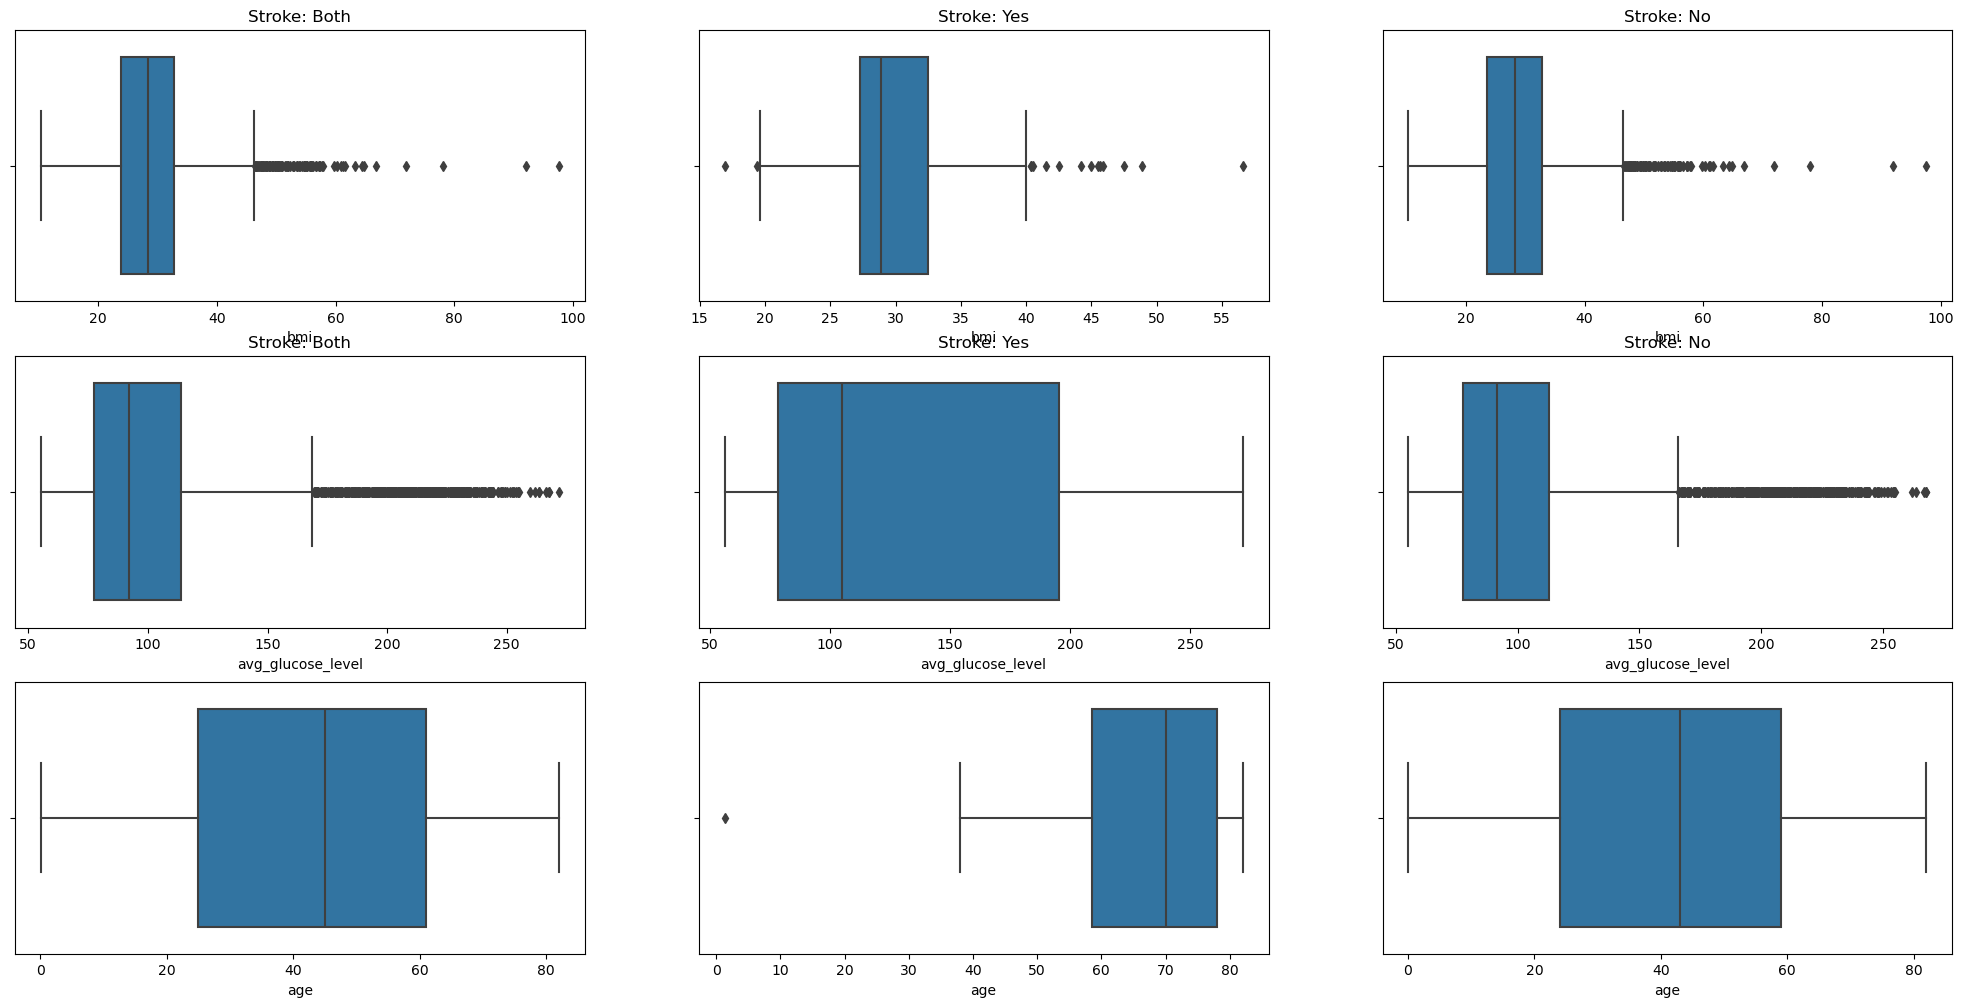

In [14]:
plot_norm = pd.concat([features_train, target_train], axis=1)

stroke_yes = plot_norm[plot_norm['stroke'] == 1]
stroke_no = plot_norm[plot_norm['stroke'] == 0]

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(25, 12))	

sns.boxplot(x=plot_norm['bmi'], ax=ax[0,0])
ax[0,0].set_title('Stroke: Both')

sns.boxplot(x=stroke_yes['bmi'], ax=ax[0,1])
ax[0,1].set_title('Stroke: Yes')

sns.boxplot(x=stroke_no['bmi'], ax=ax[0,2])
ax[0,2].set_title('Stroke: No')

sns.boxplot(x=plot_norm['avg_glucose_level'], ax=ax[1,0])
ax[1,0].set_title('Stroke: Both')

sns.boxplot(x=stroke_yes['avg_glucose_level'], ax=ax[1,1])
ax[1,1].set_title('Stroke: Yes')

sns.boxplot(x=stroke_no['avg_glucose_level'], ax=ax[1,2])
ax[1,2].set_title('Stroke: No')

sns.boxplot(x=plot_norm['age'], ax=ax[2,0])
ax[1,0].set_title('Stroke: Both')

sns.boxplot(x=stroke_yes['age'], ax=ax[2,1])
ax[1,1].set_title('Stroke: Yes')

sns.boxplot(x=stroke_no['age'], ax=ax[2,2])
ax[1,2].set_title('Stroke: No')